In [63]:
import pandas as pd
df=pd.read_csv('P1.csv')
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,Time,Delta_t,c1_x,c1_y,c1_z,c1_vx,c1_vy,c1_vz,c1_t,c2_x,c2_y,c2_z,c2_vx,c2_vy,c2_vz,c2_t,c3_x,c3_y,c3_z,c3_vx,c3_vy,c3_vz,c3_t,c4_x,c4_y,c4_z,c4_vx,c4_vy,c4_vz,c4_t,c5_x,c5_y,c5_z,c5_vx,c5_vy,c5_vz,c5_t,True_x,True_y,True_z,True_vx,True_vy,True_vz,Approx_x,Approx_y,Approx_z,Approx_vx,Approx_vy,Approx_vz
0,0,0.0,0.0,-6.409894,-67.908324,2.485850,0.076227,0.002874,-0.001670,-10725.092378,-60.424817,-5319.846789,20.588670,5.874838,0.051738,0.019943,-97623.839019,-103.311418,-26879.993718,-69.929065,29.481861,0.127468,0.028329,-219562.025382,751.169781,-111313.044376,56.326956,122.639912,1.215576,0.145444,-452299.364688,3679.293225,-249575.056267,-150.612547,275.296167,5.073458,-0.138456,-672102.787275,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14
1,1,0.0,300.0,-11.912883,-178.463405,2.590256,0.198689,0.007096,0.004073,-17801.666518,-76.037030,-7229.537537,26.122715,7.982098,0.024555,-0.025836,-113442.639165,-85.759574,-32487.219945,-60.419907,35.678022,0.144298,0.066751,-241972.327585,411.638310,-103959.168193,-128.952271,114.301759,1.131543,-0.034289,-437324.334719,3570.547579,-244748.526768,-181.348416,269.677579,5.161352,-0.022072,-666020.259607,6.886238e+06,-1.647001e-02,1.112339e-03,6.896194e+00,7609.896042,-1.551917e-06,6.886238e+06,-7.042190e-11,-1.032813e-10,6.896371e+00,7609.896139,-4.783620e-14
2,2,0.0,600.0,-10.764104,-108.981466,-3.250745,0.120754,0.006927,0.001847,-13657.466810,-82.408149,-8569.496004,-29.216900,9.401612,0.058224,-0.022051,-123248.001135,-79.812750,-27618.516878,72.567449,30.462141,0.139269,-0.012118,-222609.258872,422.008787,-106916.767697,-105.613057,117.720936,1.145403,-0.086944,-443333.757555,4503.334065,-255138.709940,128.106268,281.144332,5.681144,-0.251754,-679351.799402,6.889161e+06,-1.372342e-02,-6.212991e-03,1.223649e+01,7609.745803,-5.552468e-05,6.889161e+06,3.439537e-10,-3.399776e-10,1.223686e+01,7609.745808,-4.436440e-13
3,3,0.0,900.0,0.000082,0.000121,-0.000017,-0.000008,-0.000012,0.000002,-19.441757,-77.274930,-7550.383545,-14.036932,8.313978,0.056923,0.035926,-115870.787977,-93.779179,-28154.031227,-55.598044,30.921760,0.122601,0.061861,-224825.532212,449.389617,-104905.777542,98.964760,115.687003,0.901850,-0.147233,-439080.652303,4695.482014,-260588.370779,135.875876,286.834087,5.537690,0.183825,-686536.541182,6.893338e+06,7.202045e-02,-3.641751e-02,1.517615e+01,7608.392963,-1.513020e-04,6.893338e+06,4.174392e-10,1.584281e-10,1.517665e+01,7608.392774,3.340220e-13
4,4,0.0,1200.0,-19.798722,-618.302093,6.792656,0.684463,0.007596,-0.006816,-33422.058565,-66.446184,-5435.002554,-6.554648,5.991065,0.050485,0.031232,-98560.170077,-98.230241,-29641.415617,-71.052794,32.519299,0.136273,0.040683,-230864.002883,789.842208,-111154.207695,104.498350,122.538441,1.332772,0.090999,-451927.174681,3760.250248,-248820.716116,-188.540091,273.861609,5.451881,0.061794,-671472.663312,6.898010e+06,2.521385e-01,-9.912217e-02,1.557404e+01,7605.321046,-2.681061e-04,6.898010e+06,8.383682e-11,1.652384e-10,1.557456e+01,7605.320709,2.614618e-13


In [100]:
df.shape

(80640, 56)

In [3]:
df.columns

Index(['Unnamed: 0', 'Time', 'Delta_t', 'c1_x', 'c1_y', 'c1_z', 'c1_vx',
       'c1_vy', 'c1_vz', 'c1_t', 'c2_x', 'c2_y', 'c2_z', 'c2_vx', 'c2_vy',
       'c2_vz', 'c2_t', 'c3_x', 'c3_y', 'c3_z', 'c3_vx', 'c3_vy', 'c3_vz',
       'c3_t', 'c4_x', 'c4_y', 'c4_z', 'c4_vx', 'c4_vy', 'c4_vz', 'c4_t',
       'c5_x', 'c5_y', 'c5_z', 'c5_vx', 'c5_vy', 'c5_vz', 'c5_t', 'True_x',
       'True_y', 'True_z', 'True_vx', 'True_vy', 'True_vz', 'Approx_x',
       'Approx_y', 'Approx_z', 'Approx_vx', 'Approx_vy', 'Approx_vz'],
      dtype='object')

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80640 entries, 0 to 80639
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  80640 non-null  int64  
 1   Time        80640 non-null  float64
 2   Delta_t     80640 non-null  float64
 3   c1_x        80640 non-null  float64
 4   c1_y        80640 non-null  float64
 5   c1_z        80640 non-null  float64
 6   c1_vx       80640 non-null  float64
 7   c1_vy       80640 non-null  float64
 8   c1_vz       80640 non-null  float64
 9   c1_t        80640 non-null  float64
 10  c2_x        80640 non-null  float64
 11  c2_y        80640 non-null  float64
 12  c2_z        80640 non-null  float64
 13  c2_vx       80640 non-null  float64
 14  c2_vy       80640 non-null  float64
 15  c2_vz       80640 non-null  float64
 16  c2_t        80640 non-null  float64
 17  c3_x        80640 non-null  float64
 18  c3_y        80640 non-null  float64
 19  c3_z        80640 non-nul

In [96]:
df.isnull().sum()

Unnamed: 0    0
Time          0
Delta_t       0
c1_x          0
c1_y          0
c1_z          0
c1_vx         0
c1_vy         0
c1_vz         0
c1_t          0
c2_x          0
c2_y          0
c2_z          0
c2_vx         0
c2_vy         0
c2_vz         0
c2_t          0
c3_x          0
c3_y          0
c3_z          0
c3_vx         0
c3_vy         0
c3_vz         0
c3_t          0
c4_x          0
c4_y          0
c4_z          0
c4_vx         0
c4_vy         0
c4_vz         0
c4_t          0
c5_x          0
c5_y          0
c5_z          0
c5_vx         0
c5_vy         0
c5_vz         0
c5_t          0
True_x        0
True_y        0
True_z        0
True_vx       0
True_vy       0
True_vz       0
Approx_x      0
Approx_y      0
Approx_z      0
Approx_vx     0
Approx_vy     0
Approx_vz     0
erro_x        0
erro_y        0
erro_z        0
erro_vx       0
erro_vy       0
erro_vz       0
dtype: int64

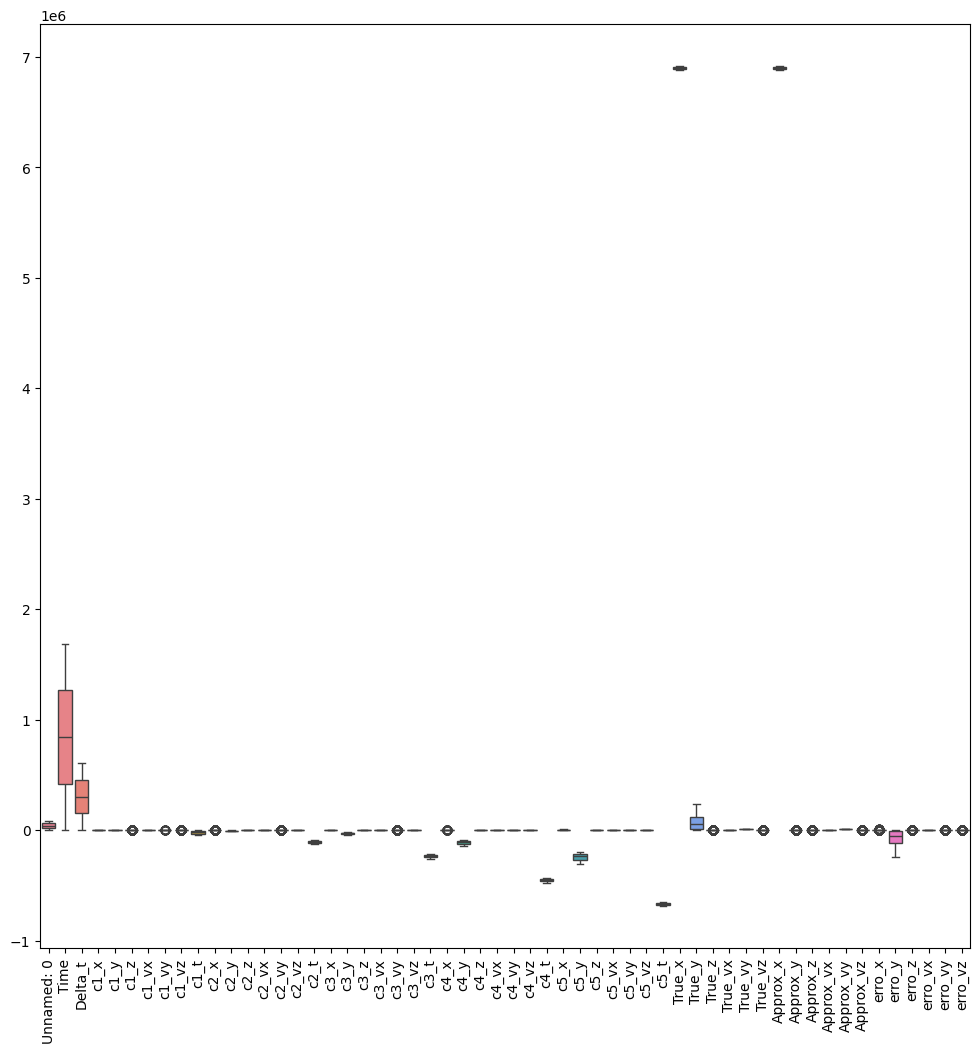

In [98]:
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.boxplot(data=df)
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor visualização
plt.show()

In [99]:
def find_outliers_iqr(data):
    outliers_dict = {}
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:  
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
            outliers_dict[column] = outliers[column]
    return outliers_dict

outliers = find_outliers_iqr(df)

for column, outliers_data in outliers.items():
    print(f"Outliers na coluna '{column}':")
    print(outliers_data)
    print("\n")

Outliers na coluna 'Unnamed: 0':
Series([], Name: Unnamed: 0, dtype: int64)


Outliers na coluna 'Time':
Series([], Name: Time, dtype: float64)


Outliers na coluna 'Delta_t':
Series([], Name: Delta_t, dtype: float64)


Outliers na coluna 'c1_x':
Series([], Name: c1_x, dtype: float64)


Outliers na coluna 'c1_y':
Series([], Name: c1_y, dtype: float64)


Outliers na coluna 'c1_z':
13       -8.829190
23       -8.304835
34       10.015358
35       10.297776
41       -9.118626
           ...    
80621   -12.942329
80622    14.112451
80633   -17.541322
80634    12.826050
80637   -17.544402
Name: c1_z, Length: 8234, dtype: float64


Outliers na coluna 'c1_vx':
Series([], Name: c1_vx, dtype: float64)


Outliers na coluna 'c1_vy':
54436    0.024624
54598    0.025002
54987    0.024147
55087    0.024845
55232    0.024991
55241    0.024158
55593    0.024467
55703    0.024153
56058    0.024828
56128    0.025067
56378    0.024311
62804    0.023954
62875    0.024140
62949    0.024121
63063    0.0241

#### Criação Label

In [64]:
df['erro_x'] =df['Approx_x']-df['True_x'] 
df['erro_y']=df['Approx_y']-df['True_y'] 
df['erro_z']=df['Approx_z']-df['True_z']
df['erro_vx']=df['Approx_vx']-df['True_vx']
df['erro_vy']=df['Approx_vy']-df['True_vy']
df['erro_vz']=df['Approx_vz']-df['True_vz']

In [9]:
df.head()

,Unnamed: 0,Time,Delta_t,c1_x,c1_y,c1_z,c1_vx,c1_vy,c1_vz,c1_t,c2_x,c2_y,c2_z,c2_vx,c2_vy,c2_vz,c2_t,c3_x,c3_y,c3_z,c3_vx,c3_vy,c3_vz,c3_t,c4_x,c4_y,c4_z,c4_vx,c4_vy,c4_vz,c4_t,c5_x,c5_y,c5_z,c5_vx,c5_vy,c5_vz,c5_t,True_x,True_y,True_z,True_vx,True_vy,True_vz,Approx_x,Approx_y,Approx_z,Approx_vx,Approx_vy,Approx_vz,erro_x,erro_y,erro_z,erro_vx,erro_vy,erro_vz
0,0,0.0,0.0,-6.409894,-67.908324,2.485850,0.076227,0.002874,-0.001670,-10725.092378,-60.424817,-5319.846789,20.588670,5.874838,0.051738,0.019943,-97623.839019,-103.311418,-26879.993718,-69.929065,29.481861,0.127468,0.028329,-219562.025382,751.169781,-111313.044376,56.326956,122.639912,1.215576,0.145444,-452299.364688,3679.293225,-249575.056267,-150.612547,275.296167,5.073458,-0.138456,-672102.787275,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.0,300.0,-11.912883,-178.463405,2.590256,0.198689,0.007096,0.004073,-17801.666518,-76.037030,-7229.537537,26.122715,7.982098,0.024555,-0.025836,-113442.639165,-85.759574,-32487.219945,-60.419907,35.678022,0.144298,0.066751,-241972.327585,411.638310,-103959.168193,-128.952271,114.301759,1.131543,-0.034289,-437324.334719,3570.547579,-244748.526768,-181.348416,269.677579,5.161352,-0.022072,-666020.259607,6.886238e+06,-1.647001e-02,1.112339e-03,6.896194e+00,7609.896042,-1.551917e-06,6.886238e+06,-7.042190e-11,-1.032813e-10,6.896371e+00,7609.896139,-4.783620e-14,0.027023,0.016470,-0.001112,0.000177,0.000097,0.000002
2,2,0.0,600.0,-10.764104,-108.981466,-3.250745,0.120754,0.006927,0.001847,-13657.466810,-82.408149,-8569.496004,-29.216900,9.401612,0.058224,-0.022051,-123248.001135,-79.812750,-27618.516878,72.567449,30.462141,0.139269,-0.012118,-222609.258872,422.008787,-106916.767697,-105.613057,117.720936,1.145403,-0.086944,-443333.757555,4503.334065,-255138.709940,128.106268,281.144332,5.681144,-0.251754,-679351.799402,6.889161e+06,-1.372342e-02,-6.212991e-03,1.223649e+01,7609.745803,-5.552468e-05,6.889161e+06,3.439537e-10,-3.399776e-10,1.223686e+01,7609.745808,-4.436440e-13,0.116288,0.013723,0.006213,0.000369,0.000005,0.000056
3,3,0.0,900.0,0.000082,0.000121,-0.000017,-0.000008,-0.000012,0.000002,-19.441757,-77.274930,-7550.383545,-14.036932,8.313978,0.056923,0.035926,-115870.787977,-93.779179,-28154.031227,-55.598044,30.921760,0.122601,0.061861,-224825.532212,449.389617,-104905.777542,98.964760,115.687003,0.901850,-0.147233,-439080.652303,4695.482014,-260588.370779,135.875876,286.834087,5.537690,0.183825,-686536.541182,6.893338e+06,7.202045e-02,-3.641751e-02,1.517615e+01,7608.392963,-1.513020e-04,6.893338e+06,4.174392e-10,1.584281e-10,1.517665e+01,7608.392774,3.340220e-13,0.241138,-0.072020,0.036418,0.000494,-0.000189,0.000151
4,4,0.0,1200.0,-19.798722,-618.302093,6.792656,0.684463,0.007596,-0.006816,-33422.058565,-66.446184,-5435.002554,-6.554648,5.991065,0.050485,0.031232,-98560.170077,-98.230241,-29641.415617,-71.052794,32.519299,0.136273,0.040683,-230864.002883,789.842208,-111154.207695,104.498350,122.538441,1.332772,0.090999,-451927.174681,3760.250248,-248820.716116,-188.540091,273.861609,5.451881,0.061794,-671472.663312,6.898010e+06,2.521385e-01,-9.912217e-02,1.557404e+01,7605.321046,-2.681061e-04,6.898010e+06,8.383682e-11,1.652384e-10,1.557456e+01,7605.320709,2.614618e-13,0.344025,-0.252139,0.099122,0.000519,-0.000337,0.000268


In [17]:
df_time_0 = df[df['Time'] == 0].head(5)
df_time_0 

,Unnamed: 0,Time,Delta_t,c1_x,c1_y,c1_z,c1_vx,c1_vy,c1_vz,c1_t,c2_x,c2_y,c2_z,c2_vx,c2_vy,c2_vz,c2_t,c3_x,c3_y,c3_z,c3_vx,c3_vy,c3_vz,c3_t,c4_x,c4_y,c4_z,c4_vx,c4_vy,c4_vz,c4_t,c5_x,c5_y,c5_z,c5_vx,c5_vy,c5_vz,c5_t,True_x,True_y,True_z,True_vx,True_vy,True_vz,Approx_x,Approx_y,Approx_z,Approx_vx,Approx_vy,Approx_vz,erro_x,erro_y,erro_z,erro_vx,erro_vy,erro_vz
0,0,0.0,0.0,-6.409894,-67.908324,2.485850,0.076227,0.002874,-0.001670,-10725.092378,-60.424817,-5319.846789,20.588670,5.874838,0.051738,0.019943,-97623.839019,-103.311418,-26879.993718,-69.929065,29.481861,0.127468,0.028329,-219562.025382,751.169781,-111313.044376,56.326956,122.639912,1.215576,0.145444,-452299.364688,3679.293225,-249575.056267,-150.612547,275.296167,5.073458,-0.138456,-672102.787275,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,6.885180e+06,1.146216e-10,-5.906133e-11,1.975155e-13,7609.474242,-2.184792e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.0,300.0,-11.912883,-178.463405,2.590256,0.198689,0.007096,0.004073,-17801.666518,-76.037030,-7229.537537,26.122715,7.982098,0.024555,-0.025836,-113442.639165,-85.759574,-32487.219945,-60.419907,35.678022,0.144298,0.066751,-241972.327585,411.638310,-103959.168193,-128.952271,114.301759,1.131543,-0.034289,-437324.334719,3570.547579,-244748.526768,-181.348416,269.677579,5.161352,-0.022072,-666020.259607,6.886238e+06,-1.647001e-02,1.112339e-03,6.896194e+00,7609.896042,-1.551917e-06,6.886238e+06,-7.042190e-11,-1.032813e-10,6.896371e+00,7609.896139,-4.783620e-14,0.027023,0.016470,-0.001112,0.000177,0.000097,0.000002
2,2,0.0,600.0,-10.764104,-108.981466,-3.250745,0.120754,0.006927,0.001847,-13657.466810,-82.408149,-8569.496004,-29.216900,9.401612,0.058224,-0.022051,-123248.001135,-79.812750,-27618.516878,72.567449,30.462141,0.139269,-0.012118,-222609.258872,422.008787,-106916.767697,-105.613057,117.720936,1.145403,-0.086944,-443333.757555,4503.334065,-255138.709940,128.106268,281.144332,5.681144,-0.251754,-679351.799402,6.889161e+06,-1.372342e-02,-6.212991e-03,1.223649e+01,7609.745803,-5.552468e-05,6.889161e+06,3.439537e-10,-3.399776e-10,1.223686e+01,7609.745808,-4.436440e-13,0.116288,0.013723,0.006213,0.000369,0.000005,0.000056
3,3,0.0,900.0,0.000082,0.000121,-0.000017,-0.000008,-0.000012,0.000002,-19.441757,-77.274930,-7550.383545,-14.036932,8.313978,0.056923,0.035926,-115870.787977,-93.779179,-28154.031227,-55.598044,30.921760,0.122601,0.061861,-224825.532212,449.389617,-104905.777542,98.964760,115.687003,0.901850,-0.147233,-439080.652303,4695.482014,-260588.370779,135.875876,286.834087,5.537690,0.183825,-686536.541182,6.893338e+06,7.202045e-02,-3.641751e-02,1.517615e+01,7608.392963,-1.513020e-04,6.893338e+06,4.174392e-10,1.584281e-10,1.517665e+01,7608.392774,3.340220e-13,0.241138,-0.072020,0.036418,0.000494,-0.000189,0.000151
4,4,0.0,1200.0,-19.798722,-618.302093,6.792656,0.684463,0.007596,-0.006816,-33422.058565,-66.446184,-5435.002554,-6.554648,5.991065,0.050485,0.031232,-98560.170077,-98.230241,-29641.415617,-71.052794,32.519299,0.136273,0.040683,-230864.002883,789.842208,-111154.207695,104.498350,122.538441,1.332772,0.090999,-451927.174681,3760.250248,-248820.716116,-188.540091,273.861609,5.451881,0.061794,-671472.663312,6.898010e+06,2.521385e-01,-9.912217e-02,1.557404e+01,7605.321046,-2.681061e-04,6.898010e+06,8.383682e-11,1.652384e-10,1.557456e+01,7605.320709,2.614618e-13,0.344025,-0.252139,0.099122,0.000519,-0.000337,0.000268


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

columns_to_select = ['Delta_t', 'c1_x', 'c1_t', 'c2_x', 'c2_t', 'c3_x', 'c3_t', 'c4_x', 'c4_t', 'c5_x', 'c5_t', 'erro_x']
selected_columns_df = df[columns_to_select]

X = selected_columns_df[['Delta_t', 'c1_x', 'c1_t', 'c2_x', 'c2_t', 'c3_x', 'c3_t', 'c4_x', 'c4_t', 'c5_x', 'c5_t']]
poly = PolynomialFeatures(degree=5, include_bias=False)

y = selected_columns_df['erro_x']

X_train, X_test, y_train, y_test, X_val, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [72]:
from sklearn.preprocessing import StandardScaler


X_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.transform(X_test)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
X_test_norm.shape



(16128, 11)

In [78]:
X_test_norm

array([[ 0.31337488, -1.89314548, -1.67205972, ...,  0.47150411,
        -0.32887398, -0.16049786],
       [ 0.4233311 , -0.67312384, -0.991422  , ...,  0.18374389,
        -1.3031299 ,  1.52209303],
       [-0.92706871,  0.09755267, -0.29086003, ..., -1.40709717,
        -0.2944527 , -0.11898924],
       ...,
       [-1.28099029, -0.38516041, -0.68512438, ..., -0.23248073,
        -0.75863877,  0.97443662],
       [-1.20367733,  0.99496623,  0.58408092, ..., -1.4995199 ,
        -0.87720927,  0.24677579],
       [-1.26380963,  0.5072398 ,  0.46800763, ...,  1.06587671,
        -1.17042999,  0.17968911]])

In [101]:
from sklearn.linear_model import LinearRegression

def regressao_linear(X_train_norm,y_train):
    model = LinearRegression()
    model.fit(X_train_norm, y_train, validation_data=(X_val, y_val))
    return model

def adaboost(X_train, )

resultado=regressao_linear(X_train_norm, y_train)


In [102]:
predict=resultado.predict(X_test)
# predict_norm.shape
# predict_norm_reshaped = predict_norm.reshape(-1, 1)
# predict=scaler.inverse_transform(predict_norm_reshaped)

In [103]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predict)

print("Mean Squared Error (MSE):", mse) #255125.98119969724
                                        # ^2 : 77724.16844499519
                                        # ^5: 50284.25539719081

Mean Squared Error (MSE): 255125.98119969718


In [104]:
real=y_test
previsto=predict
delta=selected_columns_df['Delta_t']
real.shape, previsto.shape, delta.shape
df_reg=pd.DataFrame(data={'Predições':previsto, 'Actuals':real})
df_reg.head()



,Predições,Actuals
47559,1180.836426,1000.661572
31495,1042.438664,697.164521
8533,-92.476278,98.436248
63735,1178.908444,946.664521
48568,-269.444285,41.130632


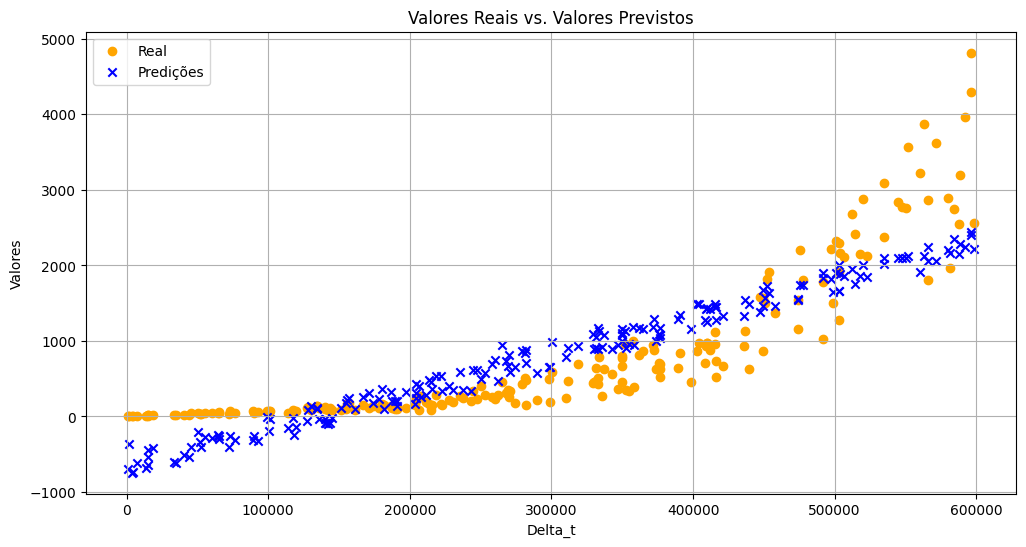

In [105]:


num_samples = 200
delta_t = X_test['Delta_t'][:num_samples]
real = df_reg['Actuals'][:num_samples]
previsto = df_reg['Predições'][:num_samples]

plt.figure(figsize=(12, 6))
plt.scatter(delta_t, real, color='orange', label='Real', marker='o')
plt.scatter(delta_t, previsto, color='blue', label='Predições', marker='x')


plt.xlabel('Delta_t')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Valores Previstos')


plt.legend()


plt.grid(True)
plt.show()